In [1]:
!wandb login

wandb: Currently logged in as: spattni. Use `wandb login --relogin` to force relogin


In [2]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from lstm_backend import CryptoDataset, LSTMRNN, LSTMBackend

In [3]:
config = {
    'epochs': 1000,
    'learning_rate': 0.01,
    'hidden_layers': 6,
    'num_layers': 1
}

In [4]:
model = LSTMBackend(data_path='BTC.feather')
model.load_data()

[BEFORE] X: (41360, 110), y: (41360,)
[BEFORE] Train: 27,711, Val: 22,169
[AFTER] X: (13649, 110), y: (13649,)
[AFTER] Train: 9,144, Val: 7,316


Train: (7316, 110) | (7316,)
Val: (1828, 110) | (1828,)
Test: (4505, 110) | (4505,)


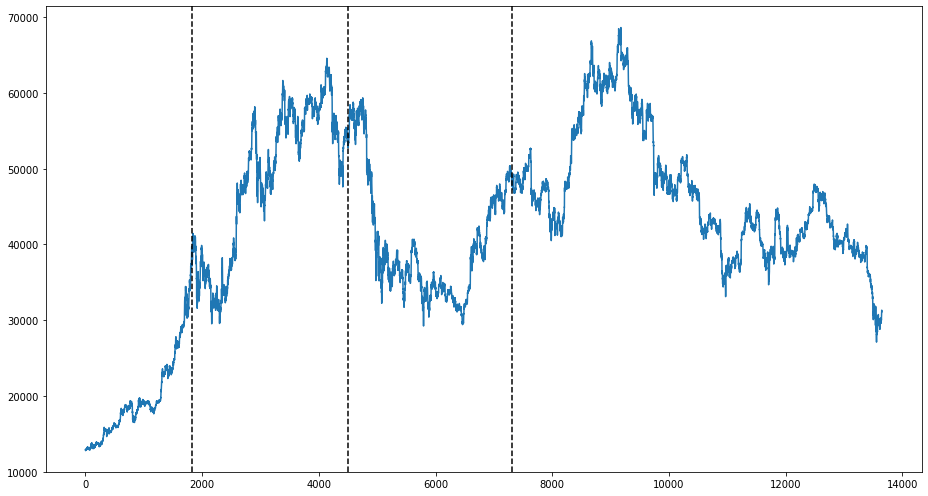

In [25]:
fig, ax = plt.subplots(figsize=(13,7))
ax.plot(model.scaler.inverse_transform(model.y_all))
plt.axvline(x=model.X_train.shape[0], color='k', linestyle='--')
plt.axvline(x=model.X_val.shape[0], color='k', linestyle='--')
plt.axvline(x=model.X_test.shape[0], color='k', linestyle='--')
plt.tight_layout()
plt.show()

In [26]:
lstm = model.train_model(config=config)

wandb: Currently logged in as: spattni. Use `wandb login --relogin` to force relogin


100%|██████████| 1000/1000 [06:57<00:00,  2.39it/s]


train/train_accuracy,▁▇▇███████▇█████▆███████▇██████▆██████▇█
train/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁███████████████▇███████████████████████
val/val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_accuracy,0.99451
train/train_loss,2e-05
val/val_accuracy,0.99467
val/val_loss,4e-05


In [27]:
torch.save(lstm.state_dict(), f'btc_lstm.pt')

In [34]:
pred, accuracy = model.evaluate_model(lstm, model.full_dl)

In [40]:
accuracy

0.9936176

In [35]:
pred.shape

(13649, 1)

No handles with labels found to put in legend.


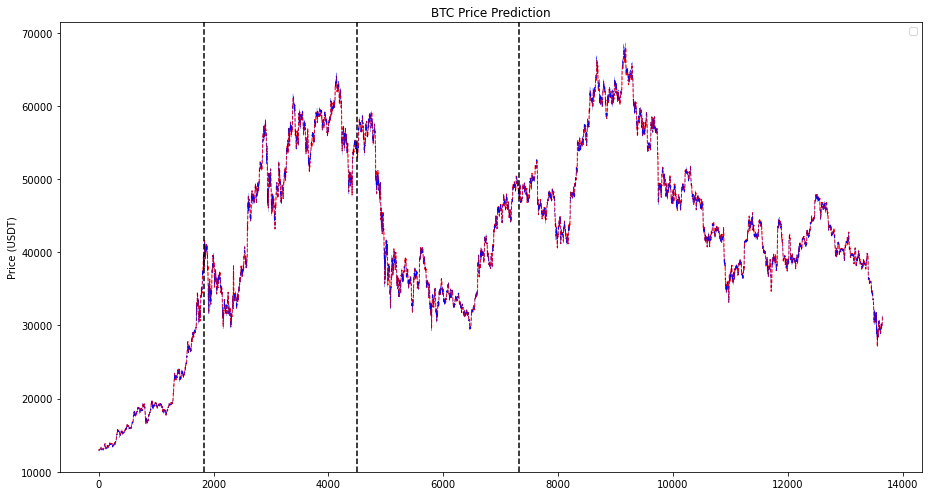

In [39]:
fig, ax = plt.subplots(figsize=(13,7))
ax.plot(model.scaler.inverse_transform(pred), '--', color='r', linewidth=1)
ax.plot(model.scaler.inverse_transform(model.y_all), color='b', linewidth=0.2)
plt.axvline(x=model.X_train.shape[0], color='k', linestyle='--')
plt.axvline(x=model.X_val.shape[0], color='k', linestyle='--')
plt.axvline(x=model.X_test.shape[0], color='k', linestyle='--')
plt.title('BTC Price Prediction')
plt.ylabel('Price (USDT)')
plt.legend()
plt.tight_layout()
plt.show()